# Lecture 13 - De novo Molecule Generation

```{contents}
:local:
:depth: 1
```

## Learning goals

- Connect **unsupervised learning** ideas to **molecular generation**.
- Explain what an **encoder** and a **decoder** are.
- Build a tiny **Autoencoder (AE)** for SMILES and discuss its limits for generation.
- Understand the **Variational Autoencoder (VAE)** idea and why it helps sampling.
- Train a small **VAE on SMILES** and generate new molecules.
- Inspect what **encode** outputs look like and how sampling works in latent space.

[![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/1uFA0HFGqZ71MP02VM3wDn_TUacgXYCJ4?usp=sharing)



## 1. Setup and data

In [1]:

# Core
import os, math, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

try:
  import deepchem as dc
except Exception:
  %pip -q install deepchem
  import deepchem as dc

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

try:
    from rdkit import Chem, RDLogger
    from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors, QED, Draw
    RD = True
except Exception:
    try:
      %pip install rdkit
      from rdkit import Chem, RDLogger
      from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors, QED, Draw
      RD = True
    except:
      print("RDKit not installed")
      RD = False
      Chem = None

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Quiet RDKit
RDLogger.DisableLog('rdApp.*')

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Device: cpu


Similar to Lecture 11, we will first build a 10 descriptor dataset for our 575 molecules loaded from C-H oxidation dataset.

In [2]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_raw = pd.read_csv(url)


def calc_descriptors10(smiles: str):
    m = Chem.MolFromSmiles(smiles)
    return pd.Series({
        "MolWt": Descriptors.MolWt(m),
        "LogP": Crippen.MolLogP(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m),
        "NumRings": rdMolDescriptors.CalcNumRings(m),
        "NumHAcceptors": rdMolDescriptors.CalcNumHBA(m),
        "NumHDonors": rdMolDescriptors.CalcNumHBD(m),
        "NumRotatableBonds": rdMolDescriptors.CalcNumRotatableBonds(m),
        "HeavyAtomCount": Descriptors.HeavyAtomCount(m),  
        "FractionCSP3": rdMolDescriptors.CalcFractionCSP3(m),
        "NumAromaticRings": rdMolDescriptors.CalcNumAromaticRings(m)
    })

desc10 = df_raw["SMILES"].apply(calc_descriptors10)   # 10 descriptors
df10 = pd.concat([df_raw, desc10], axis=1)
df10


,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site,MolWt,LogP,TPSA,NumRings,NumHAcceptors,NumHDonors,NumRotatableBonds,HeavyAtomCount,FractionCSP3,NumAromaticRings
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10",134.178,1.7593,9.23,2.0,1.0,0.0,0.0,10.0,0.333333,1.0
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7,166.223,3.2578,0.00,3.0,0.0,0.0,0.0,13.0,0.076923,2.0
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10",132.206,2.5654,0.00,2.0,0.0,0.0,0.0,10.0,0.400000,1.0
3,ethylbenzene,100-41-4,CCc1ccccc1,0.048107,5.87,non_toxic,65.0,1,"1,2",106.168,2.2490,0.00,1.0,0.0,0.0,1.0,8.0,0.250000,1.0
4,cyclohexene,110-83-8,C1=CCCCC1,0.060688,5.66,non_toxic,96.4,1,"3,6",82.146,2.1166,0.00,1.0,0.0,0.0,0.0,6.0,0.666667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,2-naphthalen-2-ylpropan-2-amine,90299-04-0,CC(C)(N)c1ccc2ccccc2c1,0.018990,10.04,toxic,121.5,-1,-1,185.270,3.0336,26.02,2.0,1.0,1.0,1.0,14.0,0.230769,2.0
571,"1-bromo-4-(methylamino)anthracene-9,10-dione",128-93-8,CNc1ccc(Br)c2c1C(=O)c1ccccc1C2=O,0.021590,7.81,toxic,154.0,-1,-1,316.154,3.2662,46.17,3.0,3.0,1.0,1.0,19.0,0.066667,2.0
572,1-[6-(dimethylamino)naphthalen-2-yl]prop-2-en-...,86636-92-2,C=CC(=O)c1ccc2cc(N(C)C)ccc2c1,0.017866,8.58,toxic,128.3,-1,-1,225.291,3.2745,20.31,2.0,2.0,0.0,3.0,17.0,0.133333,2.0
573,"1,2-dimethoxy-12-methyl-[1,3]benzodioxolo[5,6-...",34316-15-9,COc1ccc2c(c[n+](C)c3c4cc5c(cc4ccc23)OCO5)c1OC,0.016210,5.54,toxic,215.6,-1,-1,348.378,3.7166,40.80,5.0,4.0,0.0,2.0,26.0,0.190476,4.0


In the previous lecture, we learned how to explore our dataset by plotting the distribution of molecular properties using histograms.

Another way is with a **mask**, which filters molecules by conditions like `molecular weight`, `LogP`, etc. Later in this class we’ll generate new molecules, so it’s helpful to see how many remain in our training set after applying these filters.

In [3]:
# New mask: MolWt between 100–400, LogP between -1 and 5
mask = (
    (df10["MolWt"].between(100, 400)) &
    (df10["LogP"].between(-1, 3)) )

# Apply sampling
df_small = df10[mask].copy().sample(min(500, mask.sum()), random_state=42)
df_small.shape

(276, 19)

## 2. Unsupervised recap with a tiny PCA

We standardize 10D descriptors and compute a 2D `PCA()` for a quick map. Recall that PCA helps us reduce complexity while preserving the main variation in the data, making it easier to visualize patterns and clusters.

Five Examples of molecules (coordinates): [[ 1.39032814 -0.29230696]
 [ 4.45009367 -0.51704755]
 [-0.50601149 -0.62038367]
 [ 4.49210377 -0.02207216]
 [-1.4659676  -0.55787823]]


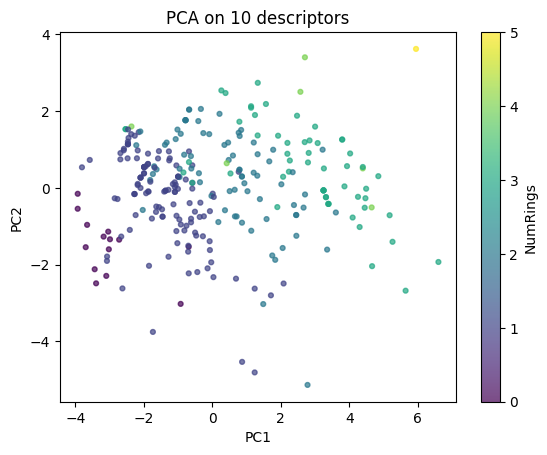

In [4]:
from sklearn.decomposition import PCA

feat_cols = ["MolWt","LogP","TPSA","NumRings","NumHAcceptors","NumHDonors",
             "NumRotatableBonds","HeavyAtomCount","FractionCSP3","NumAromaticRings"]
X = df_small[feat_cols].to_numpy(dtype=float)
scaler = StandardScaler().fit(X)
Xz = scaler.transform(X)

pca = PCA(n_components=2).fit(Xz)
Zp = pca.transform(Xz)
print(f"Five Examples of molecules (coordinates): {Zp[:5]}")


plt.scatter(Zp[:,0], Zp[:,1], c=df_small["NumRings"], cmap="viridis", s=12, alpha=0.7)
plt.colorbar(label="NumRings")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA on 10 descriptors")
plt.show()



In the scatter plot we colored the points by the number of rings. This is not required every time, and you could just use a single color for all points. Adding a property as color is simply a way to help you better visualize patterns in the PCA map.

In the scatter plot we colored the points by the number of rings. This is not required every time, and you could just use a single color for all points. Adding a property as color is simply a way to help you better visualize patterns in the PCA map.

Below we look at `loadings` to see which descriptors drive PC1.

In [5]:
loadings = pd.Series(pca.components_[0], index=feat_cols).sort_values()
loadings


FractionCSP3        -0.258801
LogP                -0.012405
NumRotatableBonds   -0.004420
NumHDonors           0.292818
NumAromaticRings     0.332956
NumRings             0.343686
NumHAcceptors        0.381308
MolWt                0.391912
TPSA                 0.393411
HeavyAtomCount       0.405417
dtype: float64

```{admonition} ⏰ Exercise 2
Replace color by `TPSA` in the PCA scatter. What region corresponds to high TPSA
```

## 3. Autoencoder on descriptors

We will train a tiny autoencoder (AE) that learns a low-dimensional summary of our 10 standardized descriptors. 

Let a molecule’s descriptor vector be:
$
x \in \mathbb{R}^{10}
$

The **encoder** is a function $f_\theta$ parameterized by weights $\theta$. It maps the input $x$ into a **latent code** $z$:

$
z = f_\theta(x), \quad z \in \mathbb{R}^2
$

The **decoder** is a function $g_\phi$ parameterized by weights $\phi$. It maps $z$ back to a reconstructed vector $\hat{x}$ in the original descriptor space:

$
\hat{x} = g_\phi(z), \quad \hat{x} \in \mathbb{R}^{10}
$

The training goal is to minimize the **reconstruction loss**, measured by the mean squared error (MSE) between the input and its reconstruction:

$
\mathcal{L}(\theta, \phi) \;=\; \frac{1}{N} \sum_{i=1}^N \lVert x_i - \hat{x}_i \rVert_2^2
\quad \text{with} \quad \hat{x}_i = g_\phi\!\big(f_\theta(x_i)\big).
$



- The **encoder** acts like a compressor: it reduces the 10D descriptor into 2D latent space.  
- The **decoder** acts like an expander: it tries to reconstruct the original 10D input from the 2D code.  
- The **loss function** measures how close the reconstructed vector is to the original input.  

By training the AE, we learn a latent space where molecules with similar properties may cluster together. Later, this latent space will be useful for generation, since we can sample points in the space and decode them into new molecular-like descriptors.
Intuitively, the encoder compresses, the decoder unpacks, and the loss measures how faithful the unpacked vector is to the input.

We now implement a very small AE in PyTorch with one hidden layer of 8 units.  

Our input has 10 features, this allows the encoder to pass through a slightly smaller hidden layer before reaching the **bottleneck size (2D)**, which forces information to be distilled.  

In other words, 
the encoder reduces 10 → 8 → 2, and the decoder reconstructs 2 → 8 → 10.

In [6]:
class TinyAE(nn.Module):
    def __init__(self, in_dim=10, hid=8, z_dim=2):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(in_dim, hid), nn.ReLU(), nn.Linear(hid, z_dim))
        self.dec = nn.Sequential(nn.Linear(z_dim, hid), nn.ReLU(), nn.Linear(hid, in_dim))
    def encode(self, x): return self.enc(x)
    def decode(self, z): return self.dec(z)
    def forward(self, x):
        z = self.enc(x)
        xr = self.dec(z)
        return xr, z

ae = TinyAE(in_dim=10, hid=8, z_dim=2)
ae


TinyAE(
  (enc): Sequential(
    (0): Linear(in_features=10, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=2, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=10, bias=True)
  )
)

We now wrap our standardized descriptors into a PyTorch dataset and build a DataLoader. The DataLoader controls how many samples are processed in each mini-batch.

Since our dataset has about 500 molecules, `Batch size = 64` is a good choice.

In [7]:
class ArrayDataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X.astype(np.float32))
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i]

ds = ArrayDataset(Xz)
dl = DataLoader(ds, batch_size=64, shuffle=True)
xb = next(iter(dl))
xb.shape, xb[0,:4]

(torch.Size([64, 10]), tensor([ 0.7818,  0.1602, -0.4250, -0.7599]))

Train for a few epochs and watch the loss.

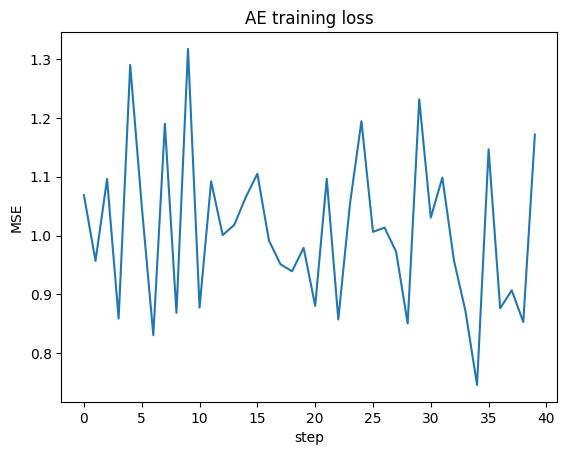

In [8]:
opt = optim.Adam(ae.parameters(), lr=1e-3)
losses = []
for ep in range(8):
    for xb in dl:
        xr, z = ae(xb)
        loss = nn.functional.mse_loss(xr, xb)
        opt.zero_grad(); loss.backward(); opt.step()
        losses.append(loss.item())
plt.plot(losses); plt.xlabel("step"); plt.ylabel("MSE"); plt.title("AE training loss"); plt.show()

After training, we use the encoder to map all molecules into the 2D latent space. Each row of `Z` is a compressed representation of one molecule. This is what **encode** returns.

In [9]:
with torch.no_grad():
    Z = ae.encode(torch.from_numpy(Xz.astype(np.float32))).numpy()
Z[:3]

array([[-0.17738552, -0.76097846],
       [-0.49888745, -1.4279171 ],
       [-0.04969665, -0.42891842]], dtype=float32)

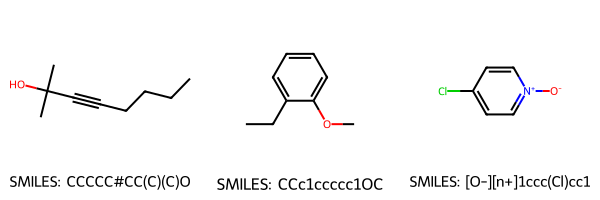

SMILES: CCCCC#CC(C)(C)O
Encoded (z1, z2): [ 0.36141846 -0.23996092]

SMILES: CCc1ccccc1OC
Encoded (z1, z2): [ 0.14926992 -0.26622495]

SMILES: [O-][n+]1ccc(Cl)cc1
Encoded (z1, z2): [ 0.02485516 -0.316418  ]



In [10]:
# Sample 3 random molecules
sample_df = df_small.sample(3, random_state=42)

# Get SMILES and mol objects
smiles_list = sample_df["SMILES"].tolist()
mol_list = [Chem.MolFromSmiles(s) for s in smiles_list]

# Encode the descriptors into latent space
with torch.no_grad():
    sample_X = scaler.transform(sample_df[feat_cols].to_numpy(dtype=float))
    Z_sample = ae.encode(torch.from_numpy(sample_X.astype(np.float32))).numpy()

# Draw molecules
img = Draw.MolsToGridImage(mol_list, molsPerRow=3, subImgSize=(200,200), legends=[f"SMILES: {s}" for s in smiles_list])
display(img)

# Print SMILES and encodings
for smi, z in zip(smiles_list, Z_sample):
    print(f"SMILES: {smi}")
    print(f"Encoded (z1, z2): {z}\n")

Plot the latent and color by LogP.

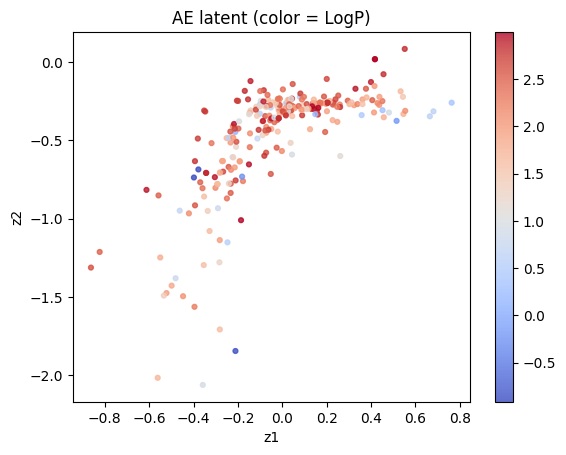

In [11]:
plt.scatter(Z[:,0], Z[:,1], c=df_small["LogP"], cmap="coolwarm", s=12, alpha=0.8)
plt.xlabel("z1"); plt.ylabel("z2"); plt.title("AE latent (color = LogP)")
plt.colorbar(); plt.show()

```{admonition} ⏰ **Exercise**
Change `z_dim` to 3 in `TinyAE` and plot the latent. Do you see any difference?
```

Below we pick one random molecule to show after autoencoder compresses descriptors into latent space, it **then reconstructs them back**:

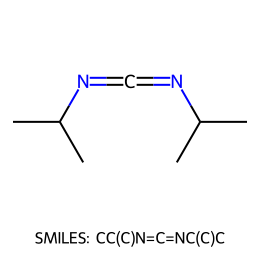

=== Roundtrip demonstration ===
SMILES: CC(C)N=C=NC(C)C
Latent z = (0.4135, -0.3231)



,Descriptor,Original,Reconstructed,AbsError
0,MolWt,126.203,187.163,60.960
1,LogP,1.977,2.071,0.094
2,TPSA,24.720,30.728,6.008
3,NumRings,0.000,1.667,1.667
4,NumHAcceptors,2.000,2.111,0.111
5,NumHDonors,0.000,0.905,0.905
6,NumRotatableBonds,2.000,1.281,0.719
7,HeavyAtomCount,9.000,13.014,4.014
8,FractionCSP3,0.857,0.242,0.615
9,NumAromaticRings,0.000,1.147,1.147


In [12]:
# Select one molecule
one_row = df_small.sample(1, random_state=7)
one_smiles = one_row["SMILES"].iloc[0]
one_mol = Chem.MolFromSmiles(one_smiles)

# Original descriptors (unscaled)
x_orig = one_row[feat_cols].to_numpy(dtype=float)

# Encode and decode (roundtrip)
with torch.no_grad():
    x_std = scaler.transform(x_orig)                                  # standardize
    z = ae.encode(torch.from_numpy(x_std.astype(np.float32))).numpy() # latent code
    x_rec_std = ae.decode(torch.from_numpy(z.astype(np.float32))).numpy()
x_rec = scaler.inverse_transform(x_rec_std)                           # back to original units

# Comparison table
df_compare = pd.DataFrame({
    "Descriptor": feat_cols,
    "Original": x_orig.flatten(),
    "Reconstructed": x_rec.flatten()
})
df_compare["AbsError"] = np.abs(df_compare["Original"] - df_compare["Reconstructed"])

# Show molecule image
img = Draw.MolsToGridImage([one_mol], molsPerRow=1, subImgSize=(260,260), legends=[f"SMILES: {one_smiles}"])
display(img)

# Print latent vector
print("=== Roundtrip demonstration ===")
print(f"SMILES: {one_smiles}")
print(f"Latent z = ({z[0,0]:.4f}, {z[0,1]:.4f})\n")

# Display table
from IPython.display import display
display(df_compare.style.format({"Original": "{:.3f}", "Reconstructed": "{:.3f}", "AbsError": "{:.3f}"}))

In the above section, we saw that using a simple autoencoder on 10 descriptors with a very narrow bottleneck (10 → 8 → 2 → 8 → 10) generally did a fair job on reconstructions but not very good. This happens because descriptors are continuous, relatively few, and do not contain enough redundancy for the network to compress and expand reliably.

A better strategy for testing reconstruction is to use **high-dimensional representations**. These vectors typically give the autoencoder much richer structure to learn from. Still, with limited data (~500) in our case it will not be perfect, but at least give you an idea of the improvement we can see:

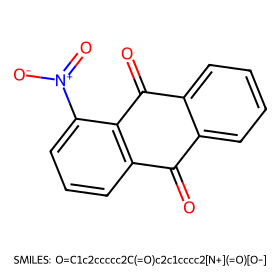

=== Random molecule roundtrip with Morgan-AE ===
SMILES: O=C1c2ccccc2C(=O)c2c1cccc2[N+](=O)[O-]
Latent z (length 32): [ 4.367 -3.068  5.747 -6.755 10.19   2.742  0.317 -1.699 -6.505 -3.996
 -0.747  2.357 -3.491  1.257 -0.324  1.643  0.116  5.637 -2.105 -0.741
 -2.766 -1.058 -2.266  2.925 -5.123 -1.284  2.473 -4.934  4.664 -0.256
  3.397  3.398]
Bit accuracy (full 512): 0.9863

First 64 original bits:
 0100000000000001000000000000000000000000000000000000000000000000100000000000000000000000000000000000
First 64 reconstructed bits:
 0100000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000

Counts:
        metric   value
0    orig ones      26
1     rec ones      23
2   agree ones      21
3  agree zeros     484
4    total acc  0.9863


In [13]:
from torch.utils.data import Dataset, DataLoader
from rdkit.Chem import AllChem, Draw

# 1) Build Morgan fingerprints from df_small["SMILES"]
#    Uses radius=2, 1024 bits for stronger capacity than 10 descriptors.
def morgan_bits(smiles, nBits=512, radius=2):
    m = Chem.MolFromSmiles(smiles)
    bv = AllChem.GetMorganFingerprintAsBitVect(m, radius=radius, nBits=nBits)
    arr = np.zeros((nBits,), dtype=np.int8)
    Chem.DataStructs.ConvertToNumpyArray(bv, arr)
    return arr

smiles_all = df_small["SMILES"].tolist()
X_bits = np.vstack([morgan_bits(s, 512, 2) for s in smiles_all]).astype(np.float32)

# 2) Dataset + DataLoader
class BitsetDS(Dataset):
    def __init__(self, X): self.X = torch.from_numpy(X)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i]
ds = BitsetDS(X_bits)
dl = DataLoader(ds, batch_size=64, shuffle=True)

# 3) AE with higher capacity; BCEWithLogitsLoss for binary recon
class MorganAE(nn.Module):
    def __init__(self, in_dim=512, h1=256, h2=128, z_dim=32):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(in_dim, h1), nn.ReLU(),
            nn.Linear(h1, h2), nn.ReLU(),
            nn.Linear(h2, z_dim)
        )
        self.dec = nn.Sequential(
            nn.Linear(z_dim, h2), nn.ReLU(),
            nn.Linear(h2, h1), nn.ReLU(),
            nn.Linear(h1, in_dim)  # logits
        )
    def encode(self, x): return self.enc(x)
    def decode_logits(self, z): return self.dec(z)  # logits
    def forward(self, x):
        z = self.encode(x)
        logits = self.decode_logits(z)
        return logits, z

ae = MorganAE()
opt = optim.Adam(ae.parameters(), lr=1e-3)
crit = nn.BCEWithLogitsLoss()

# 4) Train (few epochs already fit very well for 1024-bit vectors)
ae.train()
for ep in range(100):
    for xb in dl:
        logits, _ = ae(xb)
        loss = crit(logits, xb)
        opt.zero_grad(); loss.backward(); opt.step()

# 5) Pick one random molecule; show SMILES, Morgan bits, latent, reconstructed bits
idx = 102
smi = smiles_all[idx]
mol = Chem.MolFromSmiles(smi)
x_bits = torch.from_numpy(X_bits[idx:idx+1])  # shape (1, 1024)

ae.eval()
with torch.no_grad():
    z = ae.encode(x_bits).numpy()[0]                                  # latent vector
    logits = ae.decode_logits(torch.from_numpy(z[None, :]).float())   # logits
    probs = torch.sigmoid(logits).numpy()[0]                          # probabilities in [0,1]
    x_rec_bits = (probs >= 0.5).astype(np.float32)                    # thresholded reconstruction
    acc = (x_rec_bits == X_bits[idx]).mean()

# 6) Display: molecule image, text summary; show first 64 bits for compact view
img = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(280, 280), legends=[f"SMILES: {smi}"])
display(img)

print("=== Random molecule roundtrip with Morgan-AE ===")
print(f"SMILES: {smi}")
print(f"Latent z (length {len(z)}): {np.round(z, 3)}")
print(f"Bit accuracy (full 512): {acc:.4f}")
print("\nFirst 64 original bits:\n", "".join(map(str, X_bits[idx, :100].astype(int))))
print("First 64 reconstructed bits:\n", "".join(map(str, x_rec_bits[:100].astype(int))))

# Also show a compact table with counts
orig_ones = int(X_bits[idx].sum())
rec_ones = int(x_rec_bits.sum())
agree_ones = int(((X_bits[idx] == 1) & (x_rec_bits == 1)).sum())
agree_zeros = int(((X_bits[idx] == 0) & (x_rec_bits == 0)).sum())
print("\nCounts:")
print(pd.DataFrame({
    "metric": ["orig ones", "rec ones", "agree ones", "agree zeros", "total acc"],
    "value": [orig_ones, rec_ones, agree_ones, agree_zeros, f"{acc:.4f}"]
}))


Note that for the **Morgan fingerprint autoencoder** the input vectors are **binary (0/1)**. In this case, we want the decoder to output logits that are turned into probabilities with a sigmoid. To measure the reconstruction, we use the **binary cross-entropy loss (BCE)**, specifically `BCEWithLogitsLoss` in PyTorch.  

The BCE loss is:

$$
\mathcal{L}_{\text{BCE}}(\theta,\phi) \;=\; - \frac{1}{N}\sum_{i=1}^N \sum_{j=1}^{1024}
\Big[ x_{ij}\,\log \sigma(\hat{x}_{ij}) + (1-x_{ij})\,\log(1-\sigma(\hat{x}_{ij})) \Big]
$$

where:  
- $x_{ij} \in \{0,1\}$ is the true fingerprint bit.  
- $\hat{x}_{ij} \in \mathbb{R}$ is the decoder’s raw output (logit).  
- $\sigma(\hat{x}_{ij}) = \tfrac{1}{1+e^{-\hat{x}_{ij}}}$ is the sigmoid that maps logits to probabilities.  


While in previous case, the **descriptor autoencoder (10 → 8 → 2 → 8 → 10)** we minimized **mean squared error (MSE)** because the inputs were continuous-valued descriptors. The loss was:
$$
\mathcal{L}_{\text{MSE}}(\theta,\phi) \;=\; \frac{1}{N}\sum_{i=1}^N \lVert x_i - \hat{x}_i \rVert_2^2
$$

where $x_i \in \mathbb{R}^{10}$ are real-valued molecular descriptors.

```{admonition} Key difference

- **Descriptors AE:** uses **MSE loss** because inputs are continuous real values.  
- **Morgan AE:** uses **BCE loss** because inputs are binary bits (0/1).  
```


## 4. Why AE is tricky for SMILES

While it is exciting to see the decoder can convert latent variable back to something similar to the input, it is important to point out a issue when it's molecule generation:  
> an autoencoder that reconstructs descriptors or fingerprints does not guarantee that the reconstructed vector actually corresponds to a real molecule or a valid SMILES string.

- With **descriptors**, the AE only learns to match numerical values (like MolWt, LogP, TPSA). A reconstructed descriptor vector might have numbers that do not correspond to any chemically valid structure. For example, a molecule cannot simultaneously have a negative molecular weight or a non-integer ring count.  

- With **fingerprints**, the AE tries to reconstruct binary patterns. A reconstructed bit vector might not map back to any actual molecule, since Morgan fingerprints are not bijective (different molecules can share fingerprints, and not every bit pattern corresponds to a valid molecule).  

So even if the AE achieves a **low reconstruction error**, there is no guarantee that $\hat{x}$ corresponds to a valid SMILES.

=== Attempt to invert descriptors to a molecule ===
Original SMILES: COC(=O)c1c[nH]c2ccc(Br)cc12
Latent z: [-0.1953  1.9592]

No molecule in the dataset matches the reconstructed descriptor targets under tight tolerances.



,SMILES,distance,MolWt,LogP,TPSA,NumRings,NumHAcceptors,NumHDonors,NumRotatableBonds,HeavyAtomCount,FractionCSP3,NumAromaticRings
564,Nc1c(N)c2ccccc2c2ccccc12,6.040,208.264,3.157,52.040,3.000,2.000,2.000,0.000,16.000,0.000,3.000
497,N#Cc1ccc(C(=O)c2ccccc2)cc1,6.440,207.232,2.789,40.860,2.000,2.000,0.000,2.000,16.000,0.000,2.000
88,O=[N+]([O-])c1ccc(Cc2ccccc2)cc1,8.458,213.236,3.186,43.140,2.000,2.000,0.000,3.000,16.000,0.077,2.000
369,CC(C)(Oc1ccc(Cl)cc1)C(=O)O,8.960,214.648,2.582,46.530,1.000,2.000,1.000,3.000,14.000,0.300,1.000
378,Nc1nc(-c2ccc(Cl)cc2)cs1,9.286,210.689,3.046,38.910,2.000,3.000,1.000,1.000,13.000,0.000,2.000


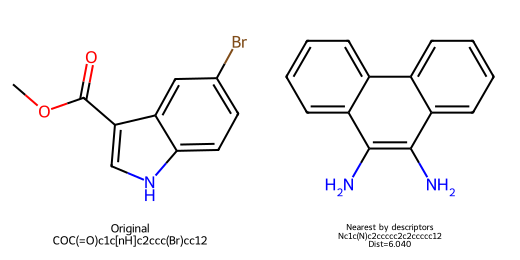

,Descriptor,Original,Recon,AbsError
0,MolWt,254.083,206.399,47.684
1,LogP,2.717,2.245,0.472
2,TPSA,42.090,46.733,4.643
3,NumRings,2.000,2.000,0.000
4,NumHAcceptors,2.000,2.000,0.000
5,NumHDonors,1.000,1.000,0.000
6,NumRotatableBonds,1.000,0.000,1.000
7,HeavyAtomCount,14.000,15.000,1.000
8,FractionCSP3,0.100,0.020,0.080
9,NumAromaticRings,2.000,2.000,0.000


In [14]:
from torch.utils.data import TensorDataset, DataLoader


# --- assumes these exist from earlier cells ---
# df10, df_small, feat_cols, scaler, Xz

# 0) Discrete/continuous fields and tolerances (your originals)
DISCRETE = ["NumRings","NumHAcceptors","NumHDonors","NumRotatableBonds","HeavyAtomCount","NumAromaticRings"]
CONTINUOUS = [c for c in feat_cols if c not in DISCRETE]
TOL = {"MolWt": 2.0, "LogP": 0.2, "TPSA": 5.0, "FractionCSP3": 0.05}

def find_match_in_dataset(target: pd.Series, df_features: pd.DataFrame):
    mask = np.ones(len(df_features), dtype=bool)
    for d in DISCRETE:
        mask &= (df_features[d].round().astype(int) == int(round(target[d])))
    for c in CONTINUOUS:
        tol = TOL.get(c, 0.5)
        mask &= (np.abs(df_features[c] - target[c]) <= tol)
    idx = np.where(mask)[0]
    return idx

def nearest_neighbors(target_vec: np.ndarray, mat: np.ndarray, k=5):
    d = np.linalg.norm(mat - target_vec[None, :], axis=1)
    order = np.argsort(d)
    return order[:k], d[order[:k]]

# 1) Define a descriptor AE separate from any Morgan AE
class TinyDescriptorAE(nn.Module):
    def __init__(self, in_dim=10, hid=8, z_dim=2):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(in_dim, hid), nn.ReLU(),
            nn.Linear(hid, z_dim)
        )
        self.dec = nn.Sequential(
            nn.Linear(z_dim, hid), nn.ReLU(),
            nn.Linear(hid, in_dim)
        )
    def encode(self, x): return self.enc(x)
    def decode(self, z): return self.dec(z)
    def forward(self, x):
        z = self.encode(x)
        xr = self.decode(z)
        return xr, z

# 2) Train desc_ae on standardized 10D descriptors
desc_ae = TinyDescriptorAE(in_dim=10, hid=8, z_dim=2)
dl = DataLoader(TensorDataset(torch.from_numpy(Xz.astype(np.float32))), batch_size=32, shuffle=True)
opt = optim.Adam(desc_ae.parameters(), lr=1e-3)
for ep in range(60):  # 60 short epochs; increase if you want tighter recon
    for (xb,) in dl:
        xr, _ = desc_ae(xb)
        loss = nn.functional.mse_loss(xr, xb)
        opt.zero_grad(); loss.backward(); opt.step()

desc_ae.eval()

# 3) Pick one molecule and do encode -> decode with the CORRECT model (desc_ae)
one = df_small.sample(1, random_state=202)
one_smiles = one["SMILES"].iloc[0]
one_mol = Chem.MolFromSmiles(one_smiles)

x_orig = one[feat_cols].to_numpy(dtype=float)             # shape (1, 10)
with torch.no_grad():
    x_std = scaler.transform(x_orig).astype(np.float32)   # standardize
    z = desc_ae.encode(torch.from_numpy(x_std)).numpy()   # latent via desc_ae
    x_rec_std = desc_ae.decode(torch.from_numpy(z.astype(np.float32))).numpy()
x_rec = scaler.inverse_transform(x_rec_std)[0]            # back to original units

# 4) Build a "constrained" target by rounding discrete fields and clipping bounds
target = pd.Series(x_rec, index=feat_cols)
for d in DISCRETE:
    target[d] = int(round(float(target[d])))
target["FractionCSP3"] = float(np.clip(target["FractionCSP3"], 0.0, 1.0))
for cnt in DISCRETE:
    target[cnt] = max(0, int(target[cnt]))

# 5) Search dataset for a feasible match under tolerances; else show nearest neighbors
df_feats_only = df10[feat_cols].copy()
matches = find_match_in_dataset(target, df_feats_only)

print("=== Attempt to invert descriptors to a molecule ===")
print(f"Original SMILES: {one_smiles}")
print(f"Latent z: {np.round(z[0], 4)}\n")

if len(matches) == 0:
    print("No molecule in the dataset matches the reconstructed descriptor targets under tight tolerances.\n")
    target_vec = target.values.astype(float)
    mat = df_feats_only.to_numpy(dtype=float)
    nn_idx, nn_dist = nearest_neighbors(target_vec, mat, k=5)
    nn_rows = df10.iloc[nn_idx][["SMILES"] + feat_cols].copy()
    nn_rows.insert(1, "distance", nn_dist)
    display(nn_rows.head(5).style.format(precision=3))
    # Draw original vs nearest by descriptors
    top1_smiles = df10.iloc[nn_idx[0]]["SMILES"]
    top1_mol = Chem.MolFromSmiles(top1_smiles)
    img = Draw.MolsToGridImage([one_mol, top1_mol], molsPerRow=2, subImgSize=(260,260),
                               legends=[f"Original\n{one_smiles}",
                                        f"Nearest by descriptors\n{top1_smiles}\nDist={nn_dist[0]:.3f}"])
    display(img)
else:
    print(f"Found {len(matches)} dataset candidate(s) matching targets under tolerances.")
    display(df10.iloc[matches][["SMILES"] + feat_cols].head(5))

# 6) Compare original vs reconstructed target values
compare = pd.DataFrame({
    "Descriptor": feat_cols,
    "Original": x_orig.flatten(),
    "Recon": [target[c] for c in feat_cols]
})
compare["AbsError"] = np.abs(compare["Original"] - compare["Recon"])
display(compare.style.format({"Original": "{:.3f}", "Recon": "{:.3f}", "AbsError": "{:.3f}"}))

In the previous example we tried to decode reconstructed descriptors back to a molecule and saw that it often fails. The reconstructed values may look **numerically close**, yet they do not correspond to any real molecule. 


With SMILES the situation becomes even more fragile. A single misplaced character is enough to make the entire string invalid. Unlike descriptors, which are continuous and can be perturbed slightly without losing “type”, SMILES is a discrete symbolic language with strict syntax rules. 
Parentheses must balance, ring indices must pair, and atom valences must be chemically possible.  



The following short experiment takes valid SMILES, applies a single random character disturbance, and checks whether the result is still valid:

In [15]:
# Helpers: SMILES validity check and single-character perturbations

def is_valid_smiles(s: str) -> bool:
    return Chem.MolFromSmiles(s) is not None

def random_char_edit(s: str, alphabet=None, p_insert=0.33, p_delete=0.33, p_sub=0.34):
    if len(s) == 0: return s
    if alphabet is None:
        # Build a basic alphabet from common SMILES chars
        alphabet = list(set(list("CNOFPSIclBr[#]=()1234567890+-@H[]\\/")))
    r = random.random()
    i = random.randrange(len(s))
    if r < p_insert:
        c = random.choice(alphabet)
        return s[:i] + c + s[i:]
    elif r < p_insert + p_delete and len(s) > 1:
        return s[:i] + s[i+1:]
    else:
        c = random.choice(alphabet)
        return s[:i] + c + s[i+1:]

# Experiment 1: one random edit kills validity most of the time
smiles_list = df_small["SMILES"].tolist()
k = min(200, len(smiles_list))
subset = random.sample(smiles_list, k)

perturbed = [random_char_edit(s) for s in subset]
valid_orig = sum(is_valid_smiles(s) for s in subset)
valid_pert = sum(is_valid_smiles(s) for s in perturbed)
print(f"Original valid: {valid_orig}/{k}  = {valid_orig/k:.2%}")
print(f"After 1 random edit valid: {valid_pert}/{k}  = {valid_pert/k:.2%}")

# Show a few examples
rows = []
for i in range(10):
    s = subset[i]
    t = perturbed[i]
    rows.append({
        "orig": s,
        "perturbed": t,
        "orig_valid": is_valid_smiles(s),
        "perturbed_valid": is_valid_smiles(t)
    })
pd.DataFrame(rows)


Original valid: 200/200  = 100.00%
After 1 random edit valid: 45/200  = 22.50%


,orig,perturbed,orig_valid,perturbed_valid
0,COc1ccc(C(=O)O)cc1,COc1ccc(C(=O))cc1,True,True
1,Nc1ccccc1C(F)(F)F,Nc1ccc8c1C(F)(F)F,True,False
2,CCOc1ccc(O)cc1,CCOc1ccc(Occ1,True,False
3,CC(C)Cc1ccccc1,CC(C)Ccccccc1,True,False
4,CCc1ccc(CC)cc1,CCc1ccc+CC)cc1,True,False
5,CCOC(=O)c1ccc(C#N)cc1,CC-OC(=O)c1ccc(C#N)cc1,True,True
6,Brc1ccc2[nH]ccc2c1,Brc1ccc2[nH]ccc2c41,True,False
7,O=c1c(=O)c2cccc3ccc4cccc1c4c32,=c1c(=O)c2cccc3ccc4cccc1c4c32,True,False
8,CC1=C(C)C(=O)CCC1,C4C1=C(C)C(=O)CCC1,True,False
9,CN(C)C(n1n[n+]([O-])c2ncccc21)=[N+](C)C.F[P-](...,CN-(C)C(n1n[n+]([O-])c2ncccc21)=[N+](C)C.F[P-]...,True,False


This motivates a VAE which gives a distribution in latent space so we can sample smoothly and then decode to strings.

## 5. Variational Autoencoder (VAE)

An AE compresses each input to a single point in latent space and learns to reconstruct that point. By constrast, a *Variational* Autoencoder (VAE) treats the latent code as a probability distribution. Instead of mapping an input to one vector, the encoder predicts a mean and a variance for a Gaussian latent. During training we sample from this Gaussian and ask the decoder to reconstruct the input from the sampled point. A **Kullback–Leibler (KL)** term softly pulls the posterior toward a simple prior such as a standard normal. The result is a latent space that is smoother and more continuous, which makes sampling new points more reliable.

This shift from **point encoding** to **distribution encoding** matters for generation. With a plain AE, latent space can be patchy. Interpolating between two codes can land you off the data manifold and the decoder struggles. 

With a VAE, the KL term discourages such patchiness. The model learns a latent space where nearby points decode to similar objects, which helps when we draw new samples from the prior. 

For SMILES generation, a well shaped latent space **does not** solve syntax by itself, but it does *reduce the chance that sampling lands in regions that decode to garbage*. In practice, VAEs pair well with more robust tokenizations or grammar constraints. Here we first build a compact VAE on the 10 standardized descriptors to make the idea concrete, then we show how to sample and decode new latent points.

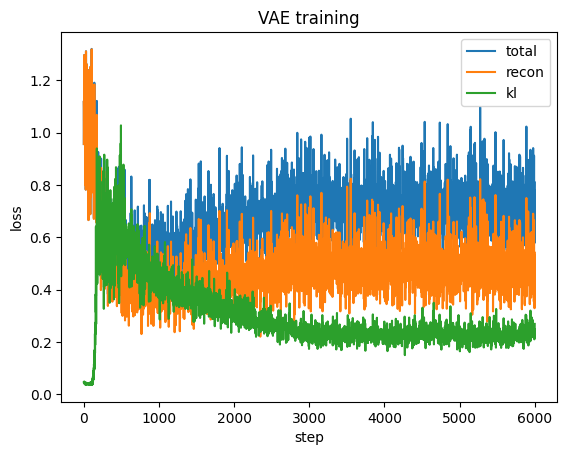

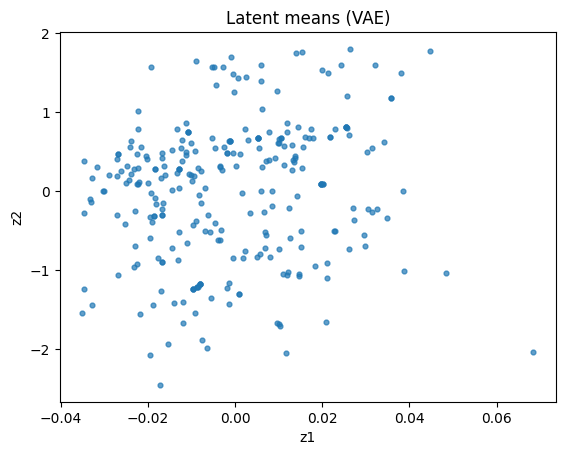

In [16]:
import torch, torch.nn as nn, torch.optim as optim

class TinyVAE(nn.Module):
    def __init__(self, in_dim=10, h=8, z_dim=2):
        super().__init__()
        # Encoder predicts mean and log-variance
        self.enc = nn.Sequential(
            nn.Linear(in_dim, h), nn.ReLU(),
            nn.Linear(h, h), nn.ReLU()
        )
        self.mu = nn.Linear(h, z_dim)
        self.logvar = nn.Linear(h, z_dim)
        # Decoder maps z back to x
        self.dec = nn.Sequential(
            nn.Linear(z_dim, h), nn.ReLU(),
            nn.Linear(h, h), nn.ReLU(),
            nn.Linear(h, in_dim)
        )
    def encode(self, x):
        h = self.enc(x)
        return self.mu(h), self.logvar(h)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        return self.dec(z)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        xr = self.decode(z)
        return xr, mu, logvar, z

def vae_loss(xr, x, mu, logvar, beta=1.0):
    # MSE recon + beta * KL
    recon = nn.functional.mse_loss(xr, x, reduction='mean')
    # KL for diagonal Gaussians: -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl, recon.item(), kl.item()

# 1) Data loader
from torch.utils.data import DataLoader, TensorDataset
X_tensor = torch.from_numpy(Xz.astype(np.float32))
dl = DataLoader(TensorDataset(X_tensor), batch_size=128, shuffle=True)

# 2) Train
vae = TinyVAE(in_dim=10, h=8, z_dim=5)
opt = optim.Adam(vae.parameters(), lr=1e-3)

steps, recon_hist, kl_hist, loss_hist = [], [], [], []
global_step = 0
epochs = 2000

for ep in range(epochs):
    # simple KL annealing from 0 -> 1 over training
    beta = min(1.0, ep / max(1, epochs//2))
    for (xb,) in dl:
        xr, mu, logvar, z = vae(xb)
        loss, r_item, k_item = vae_loss(xr, xb, mu, logvar, beta=beta)
        opt.zero_grad(); loss.backward(); opt.step()
        loss_hist.append(loss.item()); recon_hist.append(r_item); kl_hist.append(k_item)
        steps.append(global_step); global_step += 1

# 3) Plot training curves
plt.figure()
plt.plot(loss_hist, label="total")
plt.plot(recon_hist, label="recon")
plt.plot(kl_hist, label="kl")
plt.legend(); plt.xlabel("step"); plt.ylabel("loss"); plt.title("VAE training")
plt.show()

# 4) Encode the dataset to latent means for visualization
vae.eval()
with torch.no_grad():
    mu_all, logvar_all = vae.encode(X_tensor)
    Z_mu = mu_all.numpy()

plt.figure()
plt.scatter(Z_mu[:,0], Z_mu[:,1], s=12, alpha=0.7)
plt.xlabel("z1"); plt.ylabel("z2"); plt.title("Latent means (VAE)")
plt.show()



The VAE maximizes the evidence lower bound (ELBO). In practice we minimize the negative ELBO, which has a reconstruction term and a KL term that regularizes the latent posterior toward the prior.

$
\mathcal{L}_{\text{VAE}}
\;=\;
\underbrace{\mathbb{E}_{q_\phi(z\mid x)}\big[\lVert x - \hat{x}\rVert_2^2\big]}_{\text{reconstruction}}
\;+\;
\beta\,\underbrace{D_{\text{KL}}\!\big(q_\phi(z\mid x)\;\|\;p(z)\big)}_{\text{regularization}} \,,
\quad p(z)=\mathcal{N}(0,I).
$

To make sampling differentiable we use the reparameterization trick:
$
z = \mu + \sigma \odot \epsilon,\quad \epsilon \sim \mathcal{N}(0, I),\quad \sigma = \exp\big(\tfrac{1}{2}\log\sigma^2\big).
$

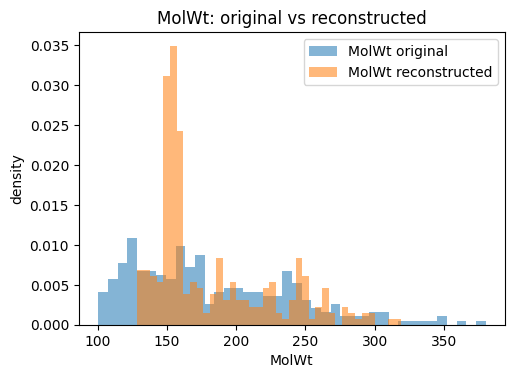

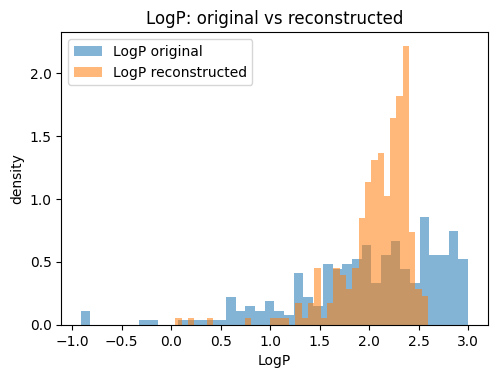

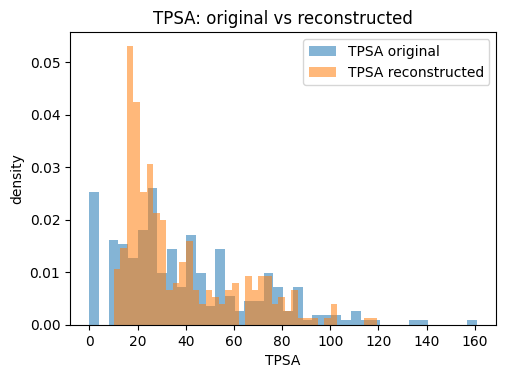

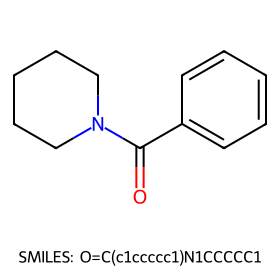

Latent mean z: [ 0.0135  0.3703  0.5941 -0.0038 -0.0104]


,Property,Original,Reconstructed,AbsError
0,MolWt,189.258,158.043,31.215
1,LogP,2.313,2.351,0.038
2,TPSA,20.310,19.841,0.469


In [17]:
# VAE distribution comparison for MolWt, LogP, TPSA + one-molecule demo

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from rdkit.Chem import Draw

# Assumes these exist: vae (trained), scaler, df_small, feat_cols, Xz

# 1) Reconstruct the whole subset deterministically via latent means
vae.eval()
X_tensor = torch.from_numpy(Xz.astype(np.float32))
with torch.no_grad():
    mu_all, logvar_all = vae.encode(X_tensor)          # [N, zdim]
    Xr_std = vae.decode(mu_all).numpy()                # standardized recon
Xr = scaler.inverse_transform(Xr_std)                   # back to original units
Xr_df = pd.DataFrame(Xr, columns=feat_cols)

# Originals for comparison
orig_df = df_small[feat_cols].reset_index(drop=True)

# 2) Pick properties to compare
props = ["MolWt", "LogP", "TPSA"]

# 3) Histograms for each property (original vs reconstructed)
bins = 40
for p in props:
    plt.figure(figsize=(5.5, 3.8))
    plt.hist(orig_df[p].values, bins=bins, alpha=0.55, label=f"{p} original", density=True)
    plt.hist(Xr_df[p].values,   bins=bins, alpha=0.55, label=f"{p} reconstructed", density=True)
    plt.xlabel(p); plt.ylabel("density"); plt.title(f"{p}: original vs reconstructed")
    plt.legend()
    plt.show()

# 4) Single random molecule: structure, latent mean, and 3-descriptor table
row = df_small.sample(1, random_state=314)
smi = row["SMILES"].iloc[0]
mol = Chem.MolFromSmiles(smi)

x_orig = row[feat_cols].to_numpy(dtype=float)          # (1, 10)
with torch.no_grad():
    x_std = scaler.transform(x_orig).astype(np.float32)
    mu, logvar = vae.encode(torch.from_numpy(x_std))
    z_mean = mu.numpy()[0]                             # latent mean (z-dim)
    x_rec_std = vae.decode(mu).numpy()                 # decode from mean
x_rec = scaler.inverse_transform(x_rec_std)            # (1, 10)

# Build a concise comparison table for the three properties
tbl = pd.DataFrame({
    "Property": props,
    "Original": [float(x_orig[0, feat_cols.index(p)]) for p in props],
    "Reconstructed": [float(x_rec[0, feat_cols.index(p)]) for p in props]
})
tbl["AbsError"] = (tbl["Original"] - tbl["Reconstructed"]).abs()

# Show structure and print outputs
img = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(280, 280), legends=[f"SMILES: {smi}"])
display(img)
print("Latent mean z:", np.round(z_mean, 4))
display(tbl.style.format({"Original": "{:.3f}", "Reconstructed": "{:.3f}", "AbsError": "{:.3f}"}))


## 6. SMILES VAE for De Novo Molecular Generation

In the previous examples, we are limited by the size of training data and the model complexicity so in general the performance is not perfect. Now, we will train a small SMILES-based Variational Autoencoder (VAE) on ~4,000 molecules, then sample new molecules and evaluate how well they match the training set.

Below are the steps:
- Load a molecular dataset with DeepChem (QM9 subset)
- Build a simple SMILES vocabulary
- Train a GRU VAE for 10-30 epochs and plot loss
- Generate new SMILES and filter invalid ones
- Evaluate validity, uniqueness, novelty
- Compare distributions of QED, logP, and molecular weight between train and generated sets

In [18]:
# Load QM9 via DeepChem (will download the dataset on first run)
tasks, datasets, transformers = dc.molnet.load_qm9(featurizer='Raw')
train_dataset, valid_dataset, test_dataset = datasets

def canonicalize_smiles(smi):
    """Return a canonical SMILES if valid, else None."""
    if not smi:
        return None
    try:
        # Parse with sanitize=False then sanitize manually to catch errors cleanly
        m = Chem.MolFromSmiles(smi, sanitize=False)
        if m is None:
            return None
        Chem.SanitizeMol(m)
        return Chem.MolToSmiles(m, canonical=True)
    except Exception:
        return None

def dataset_to_smiles(ds, max_n=None):
    """Extract canonical SMILES from a DeepChem dataset of RDKit mols with progress updates."""
    out = []
    n = len(ds.X) if max_n is None else min(len(ds.X), max_n)
    step = max(1, n // 10)  # every 10%
    for i in range(n):
        mol = ds.X[i]
        if mol is not None:
            try:
                smi = Chem.MolToSmiles(mol, canonical=True)
                can = canonicalize_smiles(smi)
                if can:
                    out.append(can)
            except Exception:
                continue
        if (i + 1) % step == 0 or i == n - 1:
            pct = int(((i + 1) / n) * 100)
            print(f"Progress: {pct}% ({i + 1}/{n})")
    return out

# Collect a pool then de-duplicate
pool_smiles = dataset_to_smiles(train_dataset, max_n=1200)
pool_smiles = list(dict.fromkeys(pool_smiles))  # keep order, remove duplicates
print("Pool size:", len(pool_smiles))

# If pool is smaller than certain number in your runtime, this will just take what's available
target_n = 2000
if len(pool_smiles) > target_n:
    rng = np.random.default_rng(SEED)
    smiles_all = rng.choice(pool_smiles, size=target_n, replace=False).tolist()
else:
    smiles_all = pool_smiles[:target_n]

print("Training pool size used:", len(smiles_all))
print("Sample:", smiles_all[:5])


KeyboardInterrupt: 

Train and validation split

In [ ]:
train_smiles, val_smiles = train_test_split(smiles_all, test_size=0.1, random_state=SEED)
len(train_smiles), len(val_smiles)



We will build a simple character-level vocabulary. The model predicts the next character given the previous ones.

In [ ]:
SPECIAL = ["[PAD]", "[SOS]", "[EOS]"]

def build_vocab(smiles_list):
    chars = set()
    for s in smiles_list:
        for ch in s:
            chars.add(ch)
    idx2ch = SPECIAL + sorted(chars)
    ch2idx = {c:i for i,c in enumerate(idx2ch)}
    return ch2idx, idx2ch

ch2idx, idx2ch = build_vocab(train_smiles)
PAD, SOS, EOS = ch2idx["[PAD]"], ch2idx["[SOS]"], ch2idx["[EOS]"]
vocab_size = len(idx2ch)

MAX_LEN = 120  # raise if many strings are longer

def smiles_to_idx(s):
    toks = [SOS] + [ch2idx[ch] for ch in s if ch in ch2idx] + [EOS]
    toks = toks[:MAX_LEN]
    attn = [1]*len(toks)
    if len(toks) < MAX_LEN:
        toks += [PAD]*(MAX_LEN - len(toks))
        attn += [0]*(MAX_LEN - len(attn))
    return np.array(toks, dtype=np.int64), np.array(attn, dtype=np.int64)

class SmilesDataset(Dataset):
    def __init__(self, smiles_list):
        enc = [smiles_to_idx(s) for s in smiles_list]
        self.toks = np.stack([e[0] for e in enc])
        self.attn = np.stack([e[1] for e in enc])
    def __len__(self):
        return len(self.toks)
    def __getitem__(self, idx):
        return torch.from_numpy(self.toks[idx]), torch.from_numpy(self.attn[idx])

train_ds = SmilesDataset(train_smiles)
val_ds   = SmilesDataset(val_smiles)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False, drop_last=False)

print("Vocab size:", vocab_size, "Train size:", len(train_ds), "Val size:", len(val_ds))
print("Index to char sample:", idx2ch[:40])


Now, we will define a tiny SMILES VAE (GRU encoder and decoder), which is a compact model that trains quickly:
- Embedding
- GRU encoder produces mean and log-variance for latent vector
- GRU decoder generates characters
- Loss = cross entropy + KL term

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hid_dim=256, z_dim=64):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD)
        self.gru = nn.GRU(emb_dim, hid_dim, batch_first=True)
        self.mu = nn.Linear(hid_dim, z_dim)
        self.logvar = nn.Linear(hid_dim, z_dim)
    def forward(self, x, attn):
        emb = self.emb(x)
        lengths = attn.sum(1).cpu()
        packed = nn.utils.rnn.pack_padded_sequence(emb, lengths, batch_first=True, enforce_sorted=False)
        _, h = self.gru(packed)
        h = h[-1]
        return self.mu(h), self.logvar(h)

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hid_dim=256, z_dim=64):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD)
        self.fc_z = nn.Linear(z_dim, hid_dim)
        self.gru = nn.GRU(emb_dim, hid_dim, batch_first=True)
        self.out = nn.Linear(hid_dim, vocab_size)
    def forward(self, z, x_in):
        h0 = self.fc_z(z).unsqueeze(0)
        emb = self.emb(x_in)
        o, _ = self.gru(emb, h0)
        return self.out(o)

class VAE(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hid_dim=256, z_dim=64):
        super().__init__()
        self.enc = Encoder(vocab_size, emb_dim, hid_dim, z_dim)
        self.dec = Decoder(vocab_size, emb_dim, hid_dim, z_dim)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def forward(self, x, attn):
        mu, logvar = self.enc(x, attn)
        z = self.reparameterize(mu, logvar)
        logits = self.dec(z, x[:, :-1])  # teacher forcing
        return logits, mu, logvar

def vae_loss(logits, x, mu, logvar, kl_weight=0.1):
    targets = x[:, 1:]
    ce = nn.functional.cross_entropy(logits.reshape(-1, logits.size(-1)),
                                     targets.reshape(-1),
                                     ignore_index=PAD)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return ce + kl_weight*kl, ce.item(), kl.item()

model = VAE(vocab_size).to(device)
opt = optim.Adam(model.parameters(), lr=2e-3)


We track both training and validation loss. Lower is better. If validation loss stops improving, consider lowering learning rate or adding early stopping.

In [ ]:
EPOCHS = 5
hist = {"train": [], "val": [], "ce": [], "kl": []}

for ep in range(1, EPOCHS+1):
    model.train()
    train_losses = []
    ce_losses = []
    kl_losses = []
    for x, a in train_loader:
        x, a = x.to(device), a.to(device)
        opt.zero_grad()
        logits, mu, logvar = model(x, a)
        loss, ce, kl = vae_loss(logits, x, mu, logvar, kl_weight=0.1)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        train_losses.append(loss.item())
        ce_losses.append(ce)
        kl_losses.append(kl)
    model.eval()
    with torch.no_grad():
        val_losses = []
        for x, a in val_loader:
            x, a = x.to(device), a.to(device)
            logits, mu, logvar = model(x, a)
            l, _, _ = vae_loss(logits, x, mu, logvar, kl_weight=0.1)
            val_losses.append(l.item())
    tr = float(np.mean(train_losses))
    va = float(np.mean(val_losses)) if len(val_losses) > 0 else float('nan')
    hist["train"].append(tr)
    hist["val"].append(va)
    hist["ce"].append(float(np.mean(ce_losses)))
    hist["kl"].append(float(np.mean(kl_losses)))
    print(f"Epoch {ep:02d} | train {tr:.3f} | val {va:.3f} | CE {np.mean(ce_losses):.3f} | KL {np.mean(kl_losses):.3f}")

# Plot training and validation loss
plt.figure(figsize=(6,4))
plt.plot(hist["train"], label="Train loss")
plt.plot(hist["val"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE loss over epochs")
plt.legend()
plt.show()


Finally, we carry out sampling and evaluation.

Sample strings from the decoder by drawing `z` from the prior.

In [ ]:
def sample_smiles(n=1500, max_len=120, temp=1.0):
    model.eval()
    out = []
    with torch.no_grad():
        z = torch.randn(n, model.enc.mu.out_features, device=device)
        x_t = torch.full((n,1), SOS, dtype=torch.long, device=device)
        h = model.dec.fc_z(z).unsqueeze(0)
        for t in range(max_len-1):
            emb = model.dec.emb(x_t[:,-1:])
            o, h = model.dec.gru(emb, h)
            logits = model.dec.out(o[:, -1])
            probs = nn.functional.softmax(logits / temp, dim=-1)
            nxt = torch.multinomial(probs, num_samples=1)
            x_t = torch.cat([x_t, nxt], dim=1)
        seqs = x_t[:, 1:].tolist()
    for seq in seqs:
        chars = []
        for idx in seq:
            ch = idx2ch[idx]
            if ch == "[EOS]":
                break
            if ch not in ("[PAD]", "[SOS]"):
                chars.append(ch)
        out.append("".join(chars))
    return out

def safe_mol_from_smiles(smi):
    if not smi:
        return None
    try:
        m = Chem.MolFromSmiles(smi, sanitize=False)
        if m is None:
            return None
        Chem.SanitizeMol(m)
        return m
    except Exception:
        return None

def canonicalize_batch(smiles_list):
    out = []
    for s in smiles_list:
        m = safe_mol_from_smiles(s)
        if m is None:
            continue
        can = Chem.MolToSmiles(m, canonical=True)
        if can:
            out.append(can)
    return out

gen_raw = sample_smiles(n=2000, temp=1.0)  # adjust temperature if desired
gen_smiles = canonicalize_batch(gen_raw)

print("Generated raw:", len(gen_raw), "Valid after sanitize:", len(gen_smiles))


Filter to valid canonical SMILES and compute metrics.

In [ ]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

def safe_mol_from_smiles(smi):
    try:
        m = Chem.MolFromSmiles(smi, sanitize=False)
        if m is None: return None
        Chem.SanitizeMol(m)
        return m
    except Exception:
        return None

def canonicalize_batch(smiles_list):
    out = []
    for s in smiles_list:
        m = safe_mol_from_smiles(s)
        if m is None: continue
        can = Chem.MolToSmiles(m, canonical=True)
        if can: out.append(can)
    return out

gen_smiles = canonicalize_batch(gen_raw)
train_set = set(train_smiles)

validity   = len(gen_smiles) / max(1, len(gen_raw))
uniq_list  = list(dict.fromkeys(gen_smiles))
uniqueness = len(uniq_list) / max(1, len(gen_smiles))
novelty    = sum(1 for s in uniq_list if s not in train_set) / max(1, len(uniq_list))

print(f"Validity: {validity:.2f}  Uniqueness: {uniqueness:.2f}  Novelty: {novelty:.2f}")

Compare property distributions.

In [ ]:
from rdkit.Chem import QED, Crippen, Descriptors

def props_from_smiles(smiles):
    rows = []
    for s in smiles:
        m = safe_mol_from_smiles(s)
        if m is None: continue
        rows.append({"SMILES": s, "QED": QED.qed(m), "logP": Crippen.MolLogP(m), "MW": Descriptors.MolWt(m)})
    return pd.DataFrame(rows)

rng = np.random.default_rng(0)
train_unique = list(set(train_smiles))
gen_unique   = list(set(gen_smiles))
train_sample = rng.choice(train_unique, size=min(3000, len(train_unique)), replace=False)
gen_sample   = rng.choice(gen_unique, size=min(3000, len(gen_unique)), replace=False)

df_train = props_from_smiles(train_sample)
df_gen   = props_from_smiles(gen_sample)

def plot_dist(metric, bins=40):
    plt.figure(figsize=(6,4))
    plt.hist(df_train[metric].dropna(), bins=bins, alpha=0.5, density=True, label="Train")
    plt.hist(df_gen[metric].dropna(),   bins=bins, alpha=0.5, density=True, label="Generated")
    plt.xlabel(metric); plt.ylabel("Density"); plt.title(f"{metric} distribution"); plt.legend(); plt.show()

for m in ["QED","logP","MW"]:
    plot_dist(m)

```{admonition} ⏰ Exercise 6
Run `sample_smiles` with temperatures 0.7 and 1.3. Which one increases validity Which one increases uniqueness How do the histograms shift
```

## 9. Glossary

```{glossary}
encoder
  A mapping from input $x$ to latent $z$.

decoder
  A mapping from latent $z$ to reconstructed $\hat x$.

autoencoder (AE)
  A model trained to reconstruct input. Learns a compact latent code.

latent space
  The internal coordinate used by the model to organize inputs.

VAE
  A probabilistic AE that learns $q_\theta(z\mid x)$ near a simple prior to enable sampling.

validity
  Fraction of generated strings that sanitize as molecules.

uniqueness
  Fraction of valid generated molecules that are unique.

novelty
  Fraction of unique generated molecules not present in the training set.
```

## 10. In-class activity with solutions

**Q1.** AE latent: change `z_dim` to 3 and plot `z[:,0]` vs `z[:,1]`. Compare to `z[:,1]` vs `z[:,2]`.

In [ ]:
ae3 = TinyAE(in_dim=10, hid=64, z_dim=3)
opt = optim.Adam(ae3.parameters(), lr=1e-3)
for ep in range(4):
    for xb in dl:
        xr, z = ae3(xb)
        loss = nn.functional.mse_loss(xr, xb)
        opt.zero_grad(); loss.backward(); opt.step()
with torch.no_grad():
    Z3 = ae3.encode(torch.from_numpy(Xz.astype(np.float32))).numpy()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.scatter(Z3[:,0], Z3[:,1], s=10, alpha=0.7); plt.xlabel("z0"); plt.ylabel("z1"); plt.title("z0 vs z1")
plt.subplot(1,2,2); plt.scatter(Z3[:,1], Z3[:,2], s=10, alpha=0.7); plt.xlabel("z1"); plt.ylabel("z2"); plt.title("z1 vs z2")
plt.tight_layout(); plt.show()

**Q2.** VAE temperature sweep: compute validity for T in [0.7, 1.0, 1.3].

In [ ]:
for t in [0.7, 1.0, 1.3]:
    raw = sample_smiles(n=800, temp=t)
    val = len(canonicalize_batch(raw)) / max(1, len(raw))
    print(f"T={t}: validity {val:.2f}")